In [2]:
!pip install -q albumentations timm segmentation_models_pytorch==0.3.3 pycocotools


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
import cv2, json, torch, numpy as np, torch.nn as nn, torch.optim as optim
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pycocotools.coco import COCO

ROOT_IMG  = Path("/home/a202152010/골절진단/data/images")
ANNO_JSON = Path("/home/a202152010/골절진단/data/Annotations/COCO JSON/COCO_fracture_masks.json")
SIZE      = (512, 512)
BATCH     = 4
EPOCHS    = 12
LR        = 1e-4
DEVICE    = "cuda" if torch.cuda.is_available() else "cpu"
print("CUDA device:", DEVICE)


CUDA device: cuda


In [4]:
class FractureSegDS(Dataset):
    def __init__(self, split, coco, tf=None, with_mask=True):
        self.paths, self.labels = [], []
        for cls, lab in [("Fractured",1), ("Non_fractured",0)]:
            for p in (ROOT_IMG/split/cls).glob("*.jpg"):
                self.paths.append(p); self.labels.append(lab)
        self.tf, self.with_mask = tf, with_mask
        self.anns = {}
        for ann in coco.dataset["annotations"]:
            fn = coco.imgs[ann["image_id"]]["file_name"]
            self.anns.setdefault(fn, []).append(ann)

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        p, lab = self.paths[idx], self.labels[idx]
        img = cv2.cvtColor(cv2.imread(str(p)), cv2.COLOR_BGR2RGB)
        h,w   = img.shape[:2]; mask = np.zeros((h,w), np.uint8)
        if lab==1 and self.with_mask:
            for ann in self.anns.get(p.name, []):
                for seg in ann["segmentation"]:
                    cv2.fillPoly(mask, [np.array(seg).reshape(-1,2).astype(np.int32)], 1)
        img  = cv2.resize(img, SIZE); mask = cv2.resize(mask, SIZE, cv2.INTER_NEAREST)
        if self.tf: aug = self.tf(image=img, mask=mask); img, mask = aug["image"], aug["mask"]
        return img, mask.unsqueeze(0).float()


In [5]:
tf_train = A.Compose([
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8,8)),
    A.HorizontalFlip(), A.RandomRotate90(),
    A.ElasticTransform(alpha=120, sigma=120*0.05, alpha_affine=30, p=0.3),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])
tf_val = A.Compose([
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8,8)),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

coco = COCO(str(ANNO_JSON))
train_dl = DataLoader(FractureSegDS("train", coco, tf_train, with_mask=True),
                      batch_size=BATCH, shuffle=True, num_workers=2)
val_dl   = DataLoader(FractureSegDS("valid", coco, tf_val,   with_mask=True),
                      batch_size=BATCH, shuffle=False, num_workers=2)
test_dl  = DataLoader(FractureSegDS("test",  coco, tf_val,   with_mask=False),
                      batch_size=1, shuffle=False)


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


/tmp/ipykernel_4083037/2129466771.py:4: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(alpha=120, sigma=120*0.05, alpha_affine=30, p=0.3),


In [7]:
# 필요 라이브러리
!pip install -q transformers timm

from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
import torch.nn as nn

feature_extractor = SegformerFeatureExtractor(do_norm=False, reduce_zero_label=False,
                                              size=512, resample=2)
model_hf = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/mit-b0", num_labels=1, ignore_mismatched_sizes=True)
# HF 모델은 logits shape=[B,1,H,W] 로 바로 나옴
model = model_hf.to(DEVICE)


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


/home/a202152010/.local/lib/python3.8/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.classifier.bias', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.3.proj.weight', 'decode_head.classifier.weight', 'decode_head.linear_c.1.proj.weight', 'decode_head.batch_norm.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.0.proj.bias', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.batch_norm.running_mean', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_

In [9]:
# ── SegFormer용 손실 함수 + 옵티마이저 선언 ───────────────────
import segmentation_models_pytorch as smp   # DiceLoss만 재사용

bce  = nn.BCEWithLogitsLoss()
dice = smp.losses.DiceLoss(mode="binary")

def loss_fn(logits, mask):
    prob = torch.sigmoid(logits)            # [B,1,H,W]
    return 0.5 * bce(logits, mask) + 0.5 * dice(prob, mask)

opt = optim.AdamW(model.parameters(), lr=LR)

In [12]:
import torch.nn.functional as F

for ep in range(1, EPOCHS+1):
    # --- train
    model.train(); total=0
    for X, y in train_dl:
        X, y = X.to(DEVICE), y.to(DEVICE)
        opt.zero_grad()
        logits = model(pixel_values=X).logits
        logits = F.interpolate(logits, size=y.shape[-2:], mode="bilinear",
                               align_corners=False)
        loss   = loss_fn(logits, y)
        loss.backward(); opt.step()
        total += loss.item()

    # --- val
    model.eval(); v_iou=v_dice=n=0
    with torch.no_grad():
        for X, y in val_dl:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits = model(pixel_values=X).logits
            logits = F.interpolate(logits, size=y.shape[-2:], mode="bilinear",
                                   align_corners=False)
            probs = torch.sigmoid(logits)
            for b in range(X.size(0)):
                v_iou  += iou(probs[b,0], y[b,0])
                v_dice += dice(probs[b], y[b]).item()
                n += 1

    print(f"Ep{ep:02d}  TrainLoss {total/len(train_dl):.4f}  "
          f"Val IoU {v_iou/n:.4f}  Dice {1-v_dice/n:.4f}")


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep01  TrainLoss 0.3377  Val IoU 0.8238  Dice 0.8254


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep02  TrainLoss 0.2807  Val IoU 0.8238  Dice 0.8254


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep03  TrainLoss 0.2747  Val IoU 0.8238  Dice 0.8254


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep04  TrainLoss 0.2759  Val IoU 0.8238  Dice 0.8254


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep05  TrainLoss 0.2712  Val IoU 0.8293  Dice 0.8255


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep06  TrainLoss 0.2709  Val IoU 0.8294  Dice 0.8254


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep07  TrainLoss 0.2699  Val IoU 0.8174  Dice 0.8255


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep08  TrainLoss 0.2691  Val IoU 0.8262  Dice 0.8255


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep09  TrainLoss 0.2667  Val IoU 0.8358  Dice 0.8255


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep10  TrainLoss 0.2716  Val IoU 0.8292  Dice 0.8256


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep11  TrainLoss 0.2680  Val IoU 0.8269  Dice 0.8256


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep12  TrainLoss 0.2688  Val IoU 0.8448  Dice 0.8256


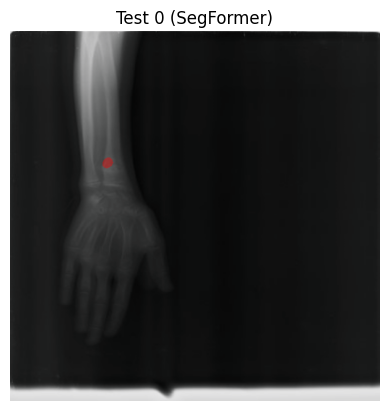

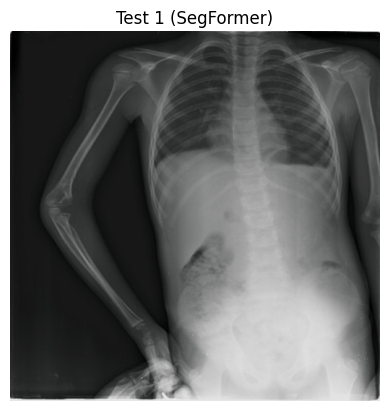

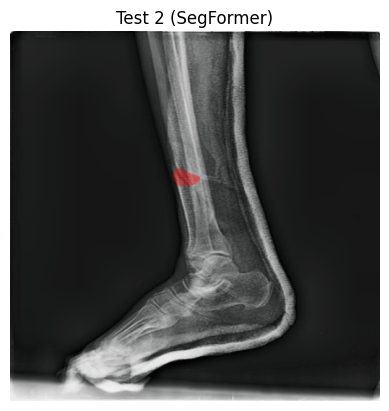

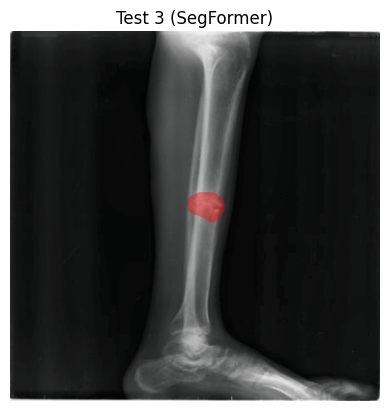

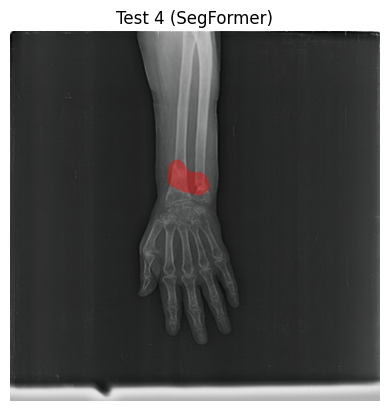

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


✅ 시각화 및 PNG 저장 완료: /home/a202152010/골절진단/visualization_results/segformer_test


In [15]:
# ── SegFormer Test 시각화 & 저장 (No-grad & detach) ────────────
from pathlib import Path
import cv2, matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

SAVE_DIR = Path("/home/a202152010/골절진단/visualization_results/segformer_test")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

def overlay(img, mask, color=(255, 0, 0), alpha=0.4):
    h, w = img.shape[:2]
    mask = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)
    tint = np.zeros_like(img); tint[:] = color
    return np.where(mask[..., None],
                    cv2.addWeighted(img, 1 - alpha, tint, alpha, 0),
                    img)

model.eval()
with torch.no_grad():                         # ← 역전파 비활성화
    for idx, (X, _) in enumerate(test_dl):
        X = X.to(DEVICE)

        # ① logits 추출 & 업샘플
        logits = model(pixel_values=X).logits
        logits = F.interpolate(logits, size=X.shape[-2:], mode="bilinear",
                               align_corners=False)

        # ② 확률 맵 → numpy
        prob = torch.sigmoid(logits)[0, 0].detach().cpu().numpy()
        pred = prob > 0.5

        # ③ 원본 복원 & 오버레이
        img = X[0].cpu().permute(1, 2, 0).numpy()
        img = np.clip(img * np.array([0.229, 0.224, 0.225])
                      + np.array([0.485, 0.456, 0.406]), 0, 1)
        viz = overlay((img * 255).astype(np.uint8), pred.astype(np.uint8))

        # ④ 저장 및 일부 샘플 표시
        out_path = SAVE_DIR / f"segformer_{idx:04d}.png"
        cv2.imwrite(str(out_path), cv2.cvtColor(viz, cv2.COLOR_RGB2BGR))

        if idx < 5:
            plt.imshow(viz); plt.axis('off')
            plt.title(f"Test {idx} (SegFormer)")
            plt.show()

print("✅ 시각화 및 PNG 저장 완료:", SAVE_DIR.resolve())